#Тестовое задание для аналитиков-стажеров / Сравни

In [ ]:
# Необходимые библиотеки
! pip install pandasql
! pip install sqlalchemy==1.4.46

In [ ]:
import pandas as pd
from pandasql import sqldf

**Важно:**

Задания на SQL (1 и 2) выполняются с использованием синтаксиса SQLite внутри Google Colab. [Ссылка](https://www.sqlite.org/lang.html) на документацию.

Но при желании вы можете выполнить эти задания с использованием любого удобного вам диалекта SQL. В данном случае вы самостоятельно выбираете где будете проверять скрипты, будете или нет нагонять туда какие-либо тестовые данные, от вас нам нужен только сам SQL запрос. Обязательно укажите диалект который вы используете.

## Задача 1 (SQL): Исследование данных E-commerce

### Описание задачи



---



**Задача:** Сформировать таблицу сессий пользователей из таблицы событий.

**Сессия** – набор последовательных событий по одному пользователю.

Событие считается первым в сессии если выполняется любое из условий:

1. Это событие - session_start
2. Предыдущие событие - session_end
3. От предыдущего события прошло более 30 минут
4. Наступил новый календарный день
5. Это первое событие пользователя за все время





Необходимо написать SQL-запрос, который создаст таблицу сессий пользователей.

Таблица должна состоять из следующих полей:
1. `SESSION_ID` – уникальный идентификатор сессии
2. `SESSION_START_DTM` – дата и время начала сессии
3. `SESSION_END_DTM` – дата и время конца сессии
4. `USER_ID` – идентификатор пользователя
5. `SESSION_NUMBER` – порядковый номер сессии для данного пользователя
6. `IS_CLIENT` – поле, которое обозначает, является ли пользователь клиентом *(пользователь является клиентом, если за всю историю у него было хотя бы одно событие purchase, не важно в рамках текущей сессии или нет)*



**Дополнительно:** сессия не может состоять только из событий session_start и session_end, такие сессии не должны попасть в результирующую таблицу и не учитываются при формировании поля SESSION_NUMBER.



---



**Схема данных таблицы EVENTS**

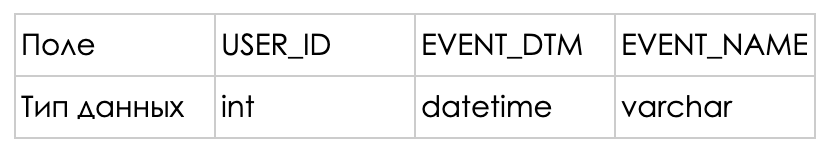

### Решение

В виде ответа на задачу необходимо прикрепить файл `result_task_1.txt` с итоговым SQL запросом в GoogleForms.

In [ ]:
# Загружаем данные
# (регистр названия DataFrame важен в SQL запросе)

events = pd.read_csv('events.csv')
events.head()

,USER_ID,EVENT_DTM,EVENT_NAME
0,921021,2023-12-01 00:13:07.000000000,event
1,921021,2023-12-01 00:13:08.000000000,event
2,193576,2023-12-01 00:13:33.000000000,event
3,193576,2023-12-01 00:13:34.000000000,event
4,921021,2023-12-01 00:17:07.000000000,event


In [ ]:
with open('result_task_1.txt', 'r') as file:
    # Читаем содержимое файла
    query = file.read()

# Сохраняем результат SQL запроса в pandas DataFrame
result_task_1 = sqldf(query, globals())
result_task_1.head()

## Задача 2 (SQL): Исследование данных Retail

### Описание задачи

Представь, что ты работаешь в retail компании, тебе предоставили доступ к данным компании с информацией о продажах товаров, пользователях компании, ассортименте продуктов, а также о магазинах сети. Общая схема данных выглядит следующим образом:

#### Схема базы данных

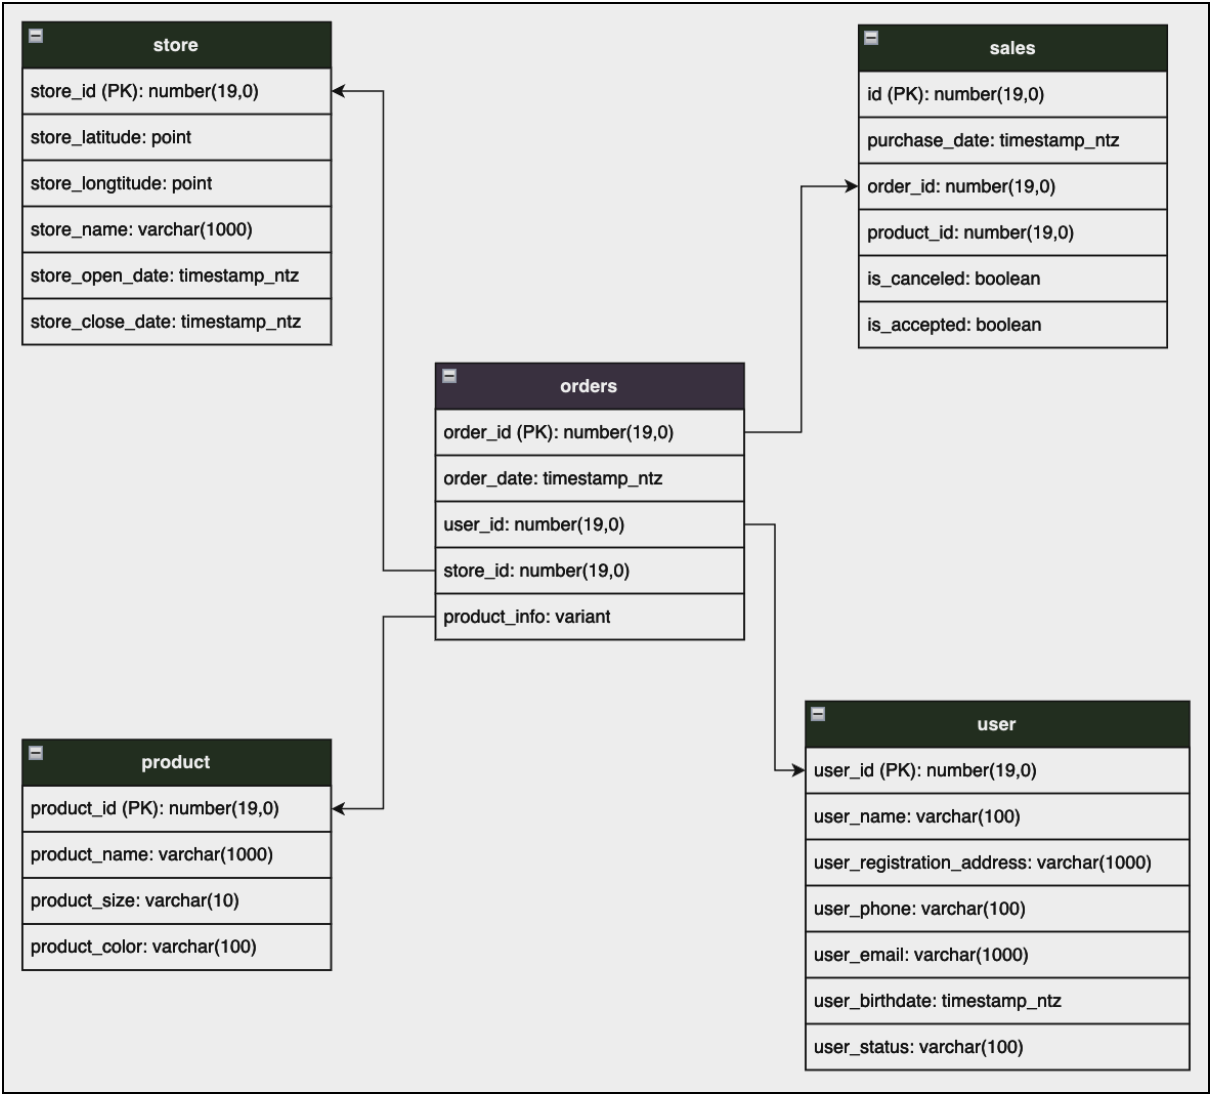

#### Описание базы данных


---



1) **orders** - таблица с информацией о созданных заказах:

* `orders.order_id`: идентификатор заказа (уникальный ключ таблицы)
* `orders.order_date`: дата создания заказа
* `orders.user_id`: идентификатор пользователя, создавшего заказ
* `orders.store_id`: идентификатор магазина, в котором был создан заказ
* `orders.product_info`: массив, содержащий json-объекты с информацией о товарах в заказе, вида:
  * `product_id` - идентификатор товара в заказе
  * `product_price` - цена товара
  * `product_commission` - комиссия за товар, учитываемая как прибыль за данный товар, получаемая компанией
  * `commission_is_percent` - флаг того, что комиссия является процентом от стоимости товара (True), либо фиксированным значением (False)
  * `count` - кол-во единиц данного продукта в заказе

**Вид массива:**

[

{"product_id":1, "product_price":1500, "product commission":70, "commission_is_percent":True, "count":2},
{"product_id":2, "product_price":2000, "product commission":1000, "commission_is_percent":False, "count":1},...

]



---



2) **sales** - таблица с информацией о продажах (совершенных платежах).
Возможные следующие случаи:
1. Если поле is_accepted=True и is_canceled=False, то произошел платеж по товару в заказе.
2. Если поле is_accepted=False и is_canceled=False, то произошло создание платежа по товару, но его еще не оплатили и не отменили.
3. Если поле is_accepted=True и is_canceled=True, то произошел возврат товара по заказу, а товар ранее был оплачен. Клиенту вернется сумма платежа.
4. Если поле is_accepted=False и is_canceled=True, то произошла отмена товара, который ранее не оплачивали.
(если статус платежа по товару меняется, то не создается новая запись в БД, а меняются поля (is_accepted, is_canceled ) в текущей записи).

**Состав таблицы:**

* `sales.id`: идентификатор продажи (уникальный ключ таблицы)
* `sales.purchase_date`: дата продажи
* `sales.order_id`: идентификатор заказа из таблицы orders, на который приходится продажа (на один заказ может быть несколько товаров, и соответственно, несколько продаж)
* `sales.product_id`: идентификатор товара в заказе
* `sales.is_accepted`: флаг подтверждения платежа
* `sales.is_canceled`: флаг подтверждения отмены платежа


---

3) **user** - таблица с информацией о клиентах:

* `user.user_id`: идентификатор пользователя (уникальный ключ таблицы)
* `user.user_name`: ФИО клиента
* `user.user_registration_address`: адрес регистрации клиента (страна/город/адрес)
* `user.user_phone`: телефон клиента
* `user.user_email`: почта клиента
* `user.user_status`: статус клиента


---


4) **store** - таблица с информацией о магазинах:

* `store.store_id`: идентификатор магазина (уникальный ключ таблицы)
* `store.store_latitude`: долгота магазина (географическая координата)
* `store.store_longtitude`: широта магазина (географическая координата)
* `store.store_name`: название магазина
* `store.store_open_date`: дата открытия магазина
* `store.store_close_date`: дата закрытия магазина



---

5) **product** - таблица с информацией о товарах:

* `product.product_id:`: идентификатор товара (уникальный ключ таблицы)
* `product.product_name`: название товара
* `product.product_size`: размер товара
* `product.product_color`: цвет товара


---



#### Постановка задачи

Необходимо создать таблицу агрегированную по пользователям и  выкупленными заказами (в заказах учитывать только выкупленные товары по которым не было возврата).



* `USER_ID` - идентификатор пользователя
* `ORDER_ID` - идентификатор заказа
* `RDER_DATE` - дата создания заказа
* `ORDER_SUM` - сумма заказа
* `ORDER_REVENUE` - выручка с заказа
* `ORDER_QUANTITY` - суммарное кол-во товаров в заказе
* `ORDER_UNIQUE_PRODUCTS` - кол-во уникальных товаров в заказе (по product_id)


### Решение

В виде ответа на задачу необходимо прикрепить файл result_task_2.txt с итоговым SQL запросом в GoogleForms.

In [ ]:
# Загружаем данные
# (регистр названия DataFrame важен в SQL запросе)

orders = pd.read_csv('orders.csv')
sales = pd.read_csv('sales.csv')
user = pd.read_csv('user.csv')
store = pd.read_csv('store.csv')
product = pd.read_csv('product.csv')

orders.head()

In [ ]:
with open('result_task_2.txt', 'r') as file:
    # Читаем содержимое файла
    query = file.read()

# Сохраняем результат SQL запроса в pandas DataFrame
result_task_2 = sqldf(query, globals())
result_task_2.head()

## Задача 3 (Python/R): Подготовка к встрече с новым владельцем сети магазинов

### Описание задачи

3.1 Завтра состоится встреча с новым владельцами бизнеса. Тебе предстоит подготовить информацию для встречи, где были бы собраны ключевые метрики, графики и сегменты на твой взгляд.

Ты можешь использовать любые данные из задачи 2, любые библиотеки и методы, которые посчитаете необходимыми. Решение предлагается сделать в свободной форме, все файлы результата и реализации выложить в GoogleDrive, ссылку прикрепить в GoogleForms (не забудь предоставить доступы). Единственное ограничение - код должен быть написан на Python или R.

3.2 У Product Ownerа есть желание понять, сколько единиц каждого товара необходимо поставить в каждый из магазинов в следующем месяце. Целью является совершить одну поставку товара в начале месяца и не довозить его больше, до начала следующего.

Ты можешь использовать любые данные из задачи 2, любые библиотеки и методы, которые посчитаете необходимыми. Решение предлагается сделать в свободной форме, все файлы результата и реализации выложить в GoogleDrive, ссылку прикрепить в GoogleForms (не забудь предоставить доступы). Единственное ограничение - код должен быть написан на Python или R.
